# 차년도 발주를 위한 발주수량 예측(SARIMA)

## 문제 상황  

A사는 매 년 차년도 발주 계획을 세우고 선발주를 통해 재고를 관리한다. 선주문을 진행하기 때문에 수요예측이 매우 중요한 역할을 한다.  
과도하게 주문할 시 창고 비용이 증가할 것이고, 적게 예측시 생산 스케줄에 대응하지 못하게 된다. 따라서 과거 발주 데이터를 활용하여  
수요예측 모델을 만들고 발주 계획에 활용하고자 한다.

## 문제 해결 프로세스  

1. 문제정의

- 선발주로 인한 창고비용 증가, 생산 스케줄 대응 장애

2. 기대효과

- 창고비용 절감, 생산 스케줄 유연하게 대응 

3. 해결방안

- 수요예측 모델 활용 재고관리

4. 성과측정

- 재고관리를 통한 감소 비용 측정

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('C:/Users/USER/Desktop/Practice Project - ETC/차년도 발주를 위한 발주 수량 예측/차년도 발주를 위한 발주 수량 예측.xlsx')
df.head()

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    82 non-null     datetime64[ns]
 1   M3      82 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [3]:
df.isnull().sum()

Date    0
M3      0
dtype: int64

#### 변수 해석 3가지  

1. 결측치 존재 여부

- 전체 데이터에서 모든 변수에 결측치가 존재하지 않는다.

- 만약, 결측치의 개수가 전체 5% 미만이면 제거해도 좋다.

- 결측치를 대체하는 경우, object형태는 최빈값으로 대체하고, float64형태는 평균으로 대체하거나 KNN을 사용할 수 있다.

2. 데이터 타입 설명

- int64형태 1개, datetime64형태 1개로 구성되어 있다.

3. 컬럼 설명

- Date : 날짜
- M3 : 자재 발주량

In [4]:
df.describe()

,M3
count,82.000000
mean,82.134146
std,79.807138
min,2.000000
25%,26.250000
50%,53.500000
75%,131.000000
max,393.000000


우선 describe로 이상치를 판단하기 위해서는 mean, min, max 값을 확인하는 것이 좋다. mean과 min, mean과 max 값이 std에 비해 한참 차이가 난다면, 이상치가 있을 가능성이 높다

이러한 이상치를 정확히 판단하기 위해서는 아래와 같이 boxplot으로 시각화하여 보는 것이 정확하다

In [5]:
df_n = df.select_dtypes(exclude = 'datetime')

In [6]:
outlier = pd.melt(df_n, var_name = '이상치 탐색 변수', value_name = '이상치 탐색 값')
outlier

,이상치 탐색 변수,이상치 탐색 값
0,M3,27
1,M3,37
2,M3,8
3,M3,9
4,M3,11
...,...,...
77,M3,310
78,M3,288
79,M3,190
80,M3,241


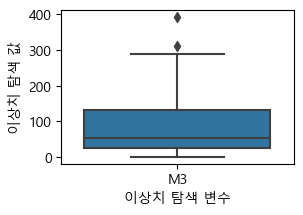

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (3,2))
sns.boxplot(x = '이상치 탐색 변수', y = '이상치 탐색 값', data = outlier)
plt.xticks(range(1), df_n.columns)
plt.show()

이상치를 탐색하기 위해서 수치형 변수만 선택해서 boxplot으로 시각화하였다. 이상치의 값이 연속적으로 나타나면, 보통 의미있는 값일 확률이 높기 때문에 따로 제거하거나 대체하지 않고, 눈에 띄는 이상치가 있을 경우에는 보통 제거하거나 대체하는 경우가 많다.(예를 들어, AGE 변수에 999값이 있다면 제거하거나 대체해야한다)

In [9]:
df['Date'].min(), df['Date'].max() 

(Timestamp('2012-01-01 00:00:00'), Timestamp('2018-10-01 00:00:00'))

2012-01-01부터 2018-10-01까지의 데이터임을 확인할 수 있다

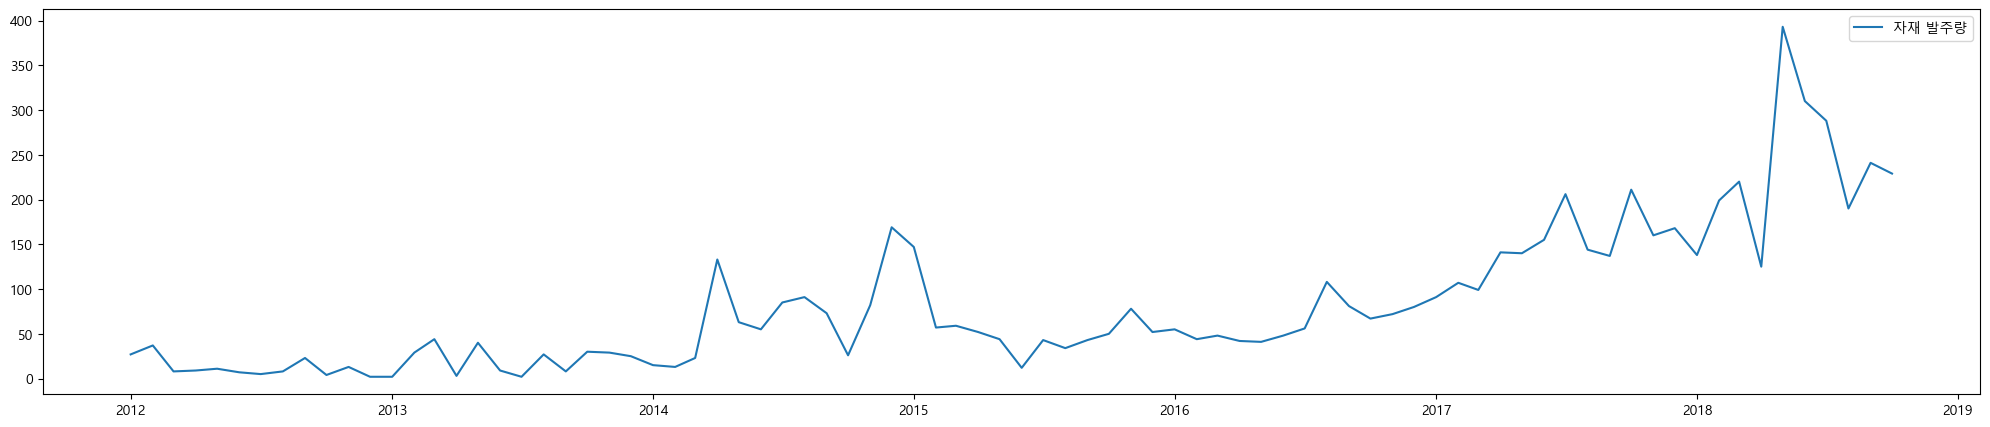

In [10]:
plt.plot(df['Date'], df['M3'], label='자재 발주량');
plt.legend();
plt.gcf().set_size_inches(25, 5)

시계열 데이터는 전체기간/연도별/월별 탐색, 패턴 파악, 민감한 반응 등 다양한 관점에서 파악해야한다. 위의 그래프는 우상향하는 추세를 보이나, 일부 기간은 움직임 파악이 어려워 일부 기간을 나눠서 다시 시각화한다

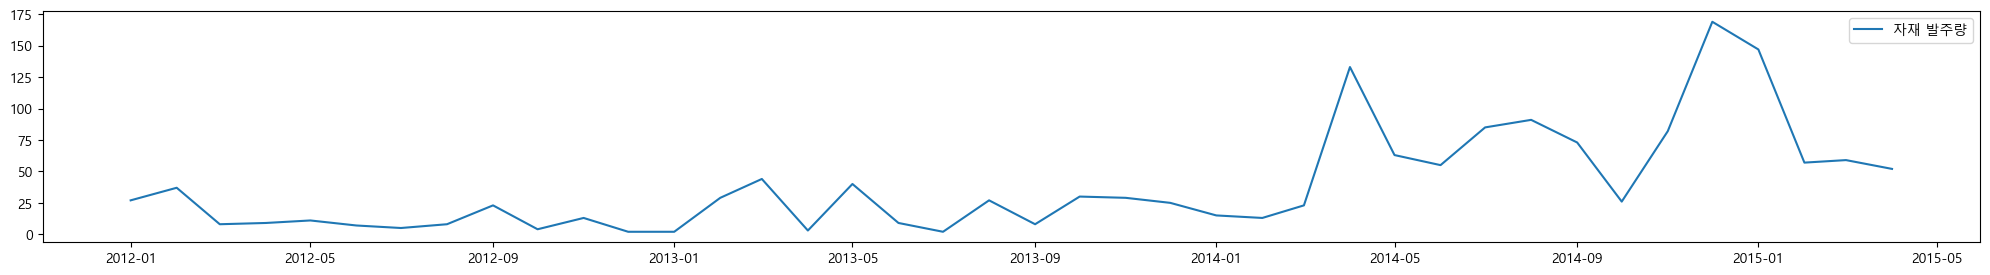

In [11]:
plt.plot(df['Date'][0:40], df['M3'][0:40], label='자재 발주량');
plt.legend();
plt.gcf().set_size_inches(25, 3)

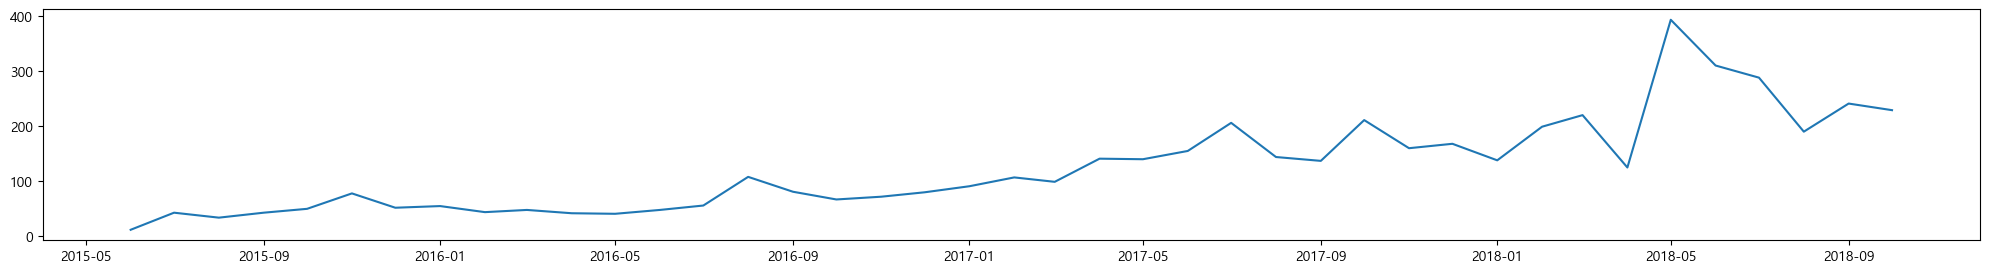

In [12]:
plt.plot(df['Date'][41:], df['M3'][41:], label='자재 발주량');
plt.gcf().set_size_inches(25, 3)

전체기간보다 더욱 패턴 파악도 용이하고 어느 기간에 peak였는지 파악이 쉽다

In [13]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df.head(5)

,Date,M3,year,month
0,2012-01-01,27,2012,1
1,2012-02-01,37,2012,2
2,2012-03-01,8,2012,3
3,2012-04-01,9,2012,4
4,2012-05-01,11,2012,5


In [14]:
df_pivot = pd.pivot_table(df,                  
                      index = 'year',          
                      columns = 'month',      
                      values = 'M3')          

df_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2012,27.0,37.0,8.0,9.0,11.0,7.0,5.0,8.0,23.0,4.0,13.0,2.0
2013,2.0,29.0,44.0,3.0,40.0,9.0,2.0,27.0,8.0,30.0,29.0,25.0
2014,15.0,13.0,23.0,133.0,63.0,55.0,85.0,91.0,73.0,26.0,82.0,169.0
2015,147.0,57.0,59.0,52.0,44.0,12.0,43.0,34.0,43.0,50.0,78.0,52.0
2016,55.0,44.0,48.0,42.0,41.0,48.0,56.0,108.0,81.0,67.0,72.0,80.0
2017,91.0,107.0,99.0,141.0,140.0,155.0,206.0,144.0,137.0,211.0,160.0,168.0
2018,138.0,199.0,220.0,125.0,393.0,310.0,288.0,190.0,241.0,229.0,NaN,NaN


pivot table을 활용해 연도별, 월별 자재 발주량 비교를 실시한다

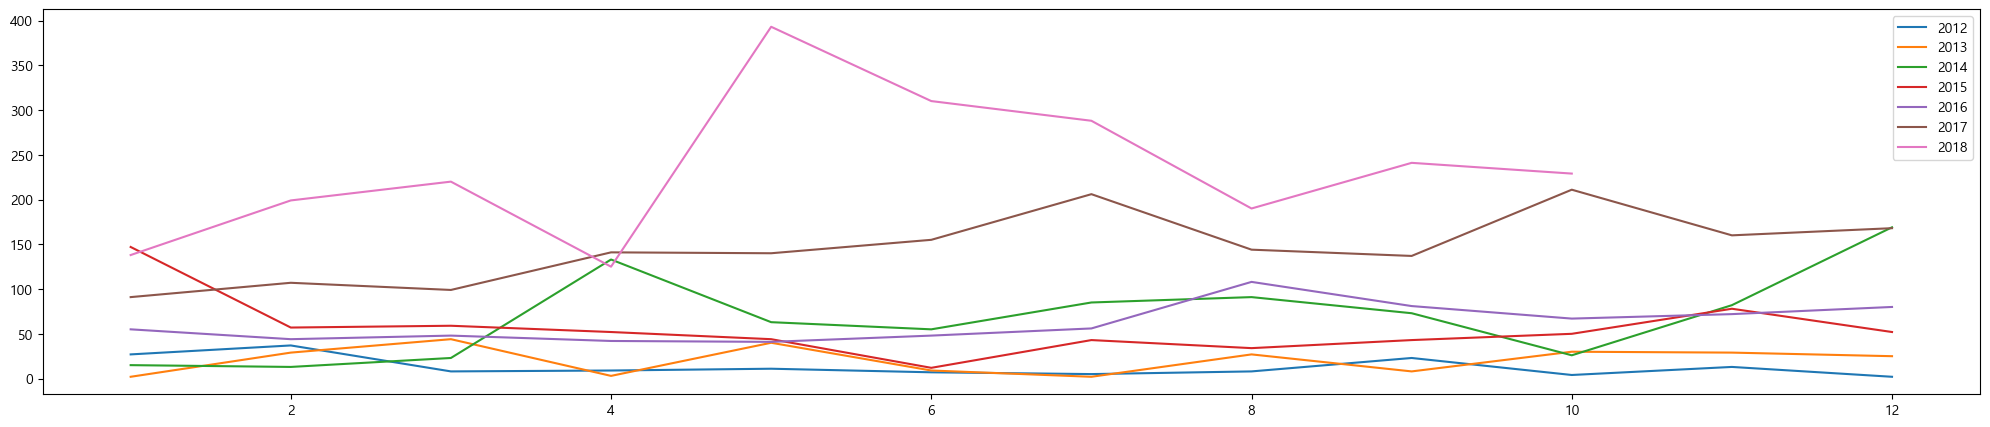

In [15]:
plt.plot(df_pivot.iloc[0,:], label='2012');
plt.plot(df_pivot.iloc[1,:], label='2013');
plt.plot(df_pivot.iloc[2,:], label='2014');
plt.plot(df_pivot.iloc[3,:], label='2015');
plt.plot(df_pivot.iloc[4,:], label='2016');
plt.plot(df_pivot.iloc[5,:], label='2017');
plt.plot(df_pivot.iloc[6,:], label='2018');
plt.legend();
plt.gcf().set_size_inches(25, 5)

기간이 오래지날수록 평균 발주량은 늘어나는 양상을 보이긴 하나, 특정한 패턴을 찾기가 어려워보인다

## 시계열 분해  

1. 시계열 데이터를 상세하게 이해하기 위한 전통적인 방법

- Trend (추세) : 시간에 따라 변화하는 Trend(우상향/우하향)
- Seasonality (계절성) : 반복되는 Trend(반복적인 패턴)
- Residual (잔차) : 그 밖에 불규칙한 패턴(특정 패턴이 없음)  

2. 고전적인 분해의 한계점

- 추세-주기 측정은 데이터에 나타나는 급격한 기울기 변화에 대해 불리하다
- 계절성이 지속적으로 반복한다는 가정에 기반하기 때문에 계절성 변화에 대해 불리하다  

3. 덧셈 분해 (additive decomposition)  

- y = S + T + R

- Trend가 일정함에 따라 변동폭이 동일하면 덧셈 분해

- Trend와 Seasonal의 관계가 없다  

4. 곱셈 분해 (multiplicative decomposition)

- y = S x T x R

- Trend가 상승함에 따라 변동폭이 변화하면 곱셈 분해

- Trend변화에 따라 Seasonal의 관계가 있다

In [16]:
df=df.set_index('Date')
df.head(5)

,M3,year,month
Date,,,
2012-01-01,27,2012,1
2012-02-01,37,2012,2
2012-03-01,8,2012,3
2012-04-01,9,2012,4
2012-05-01,11,2012,5


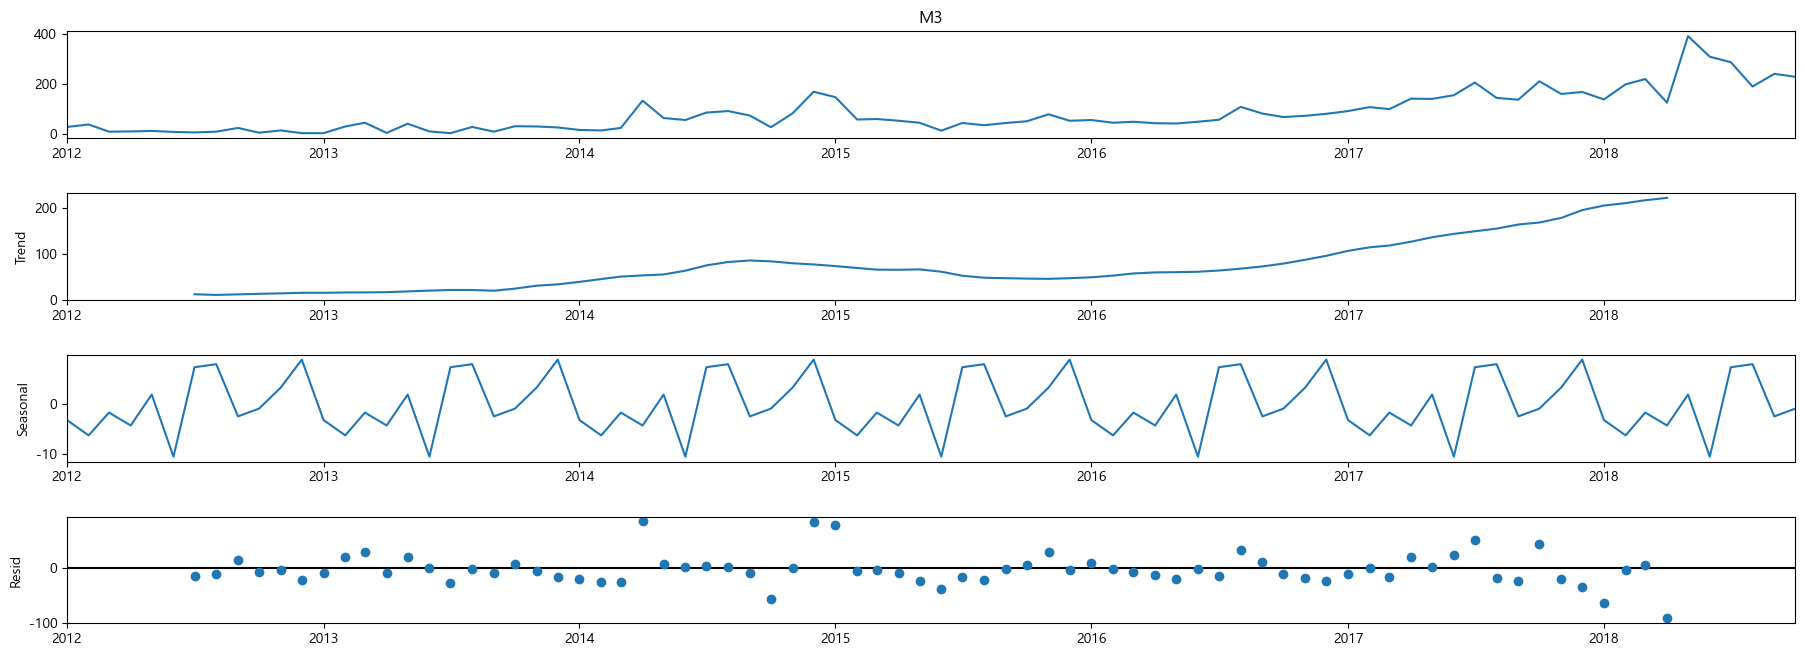

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df['M3'],model='addictive')
res.plot()
plt.gcf().set_size_inches(20, 7)

seasonal_decompose를 통해 덧셈 분해를 실시한다

상위 그래프부터 observed(전체 관측치), Trend(추세), Seasonality(계절성), Residual(잔차)를 나타내준다  

- Trend(추세) = 시간에 따라 우상향
- Seasonality(계절성) = 반복적인 패턴 존재
- Residual(잔차) = 백색잡음(특정 패턴이 없음)

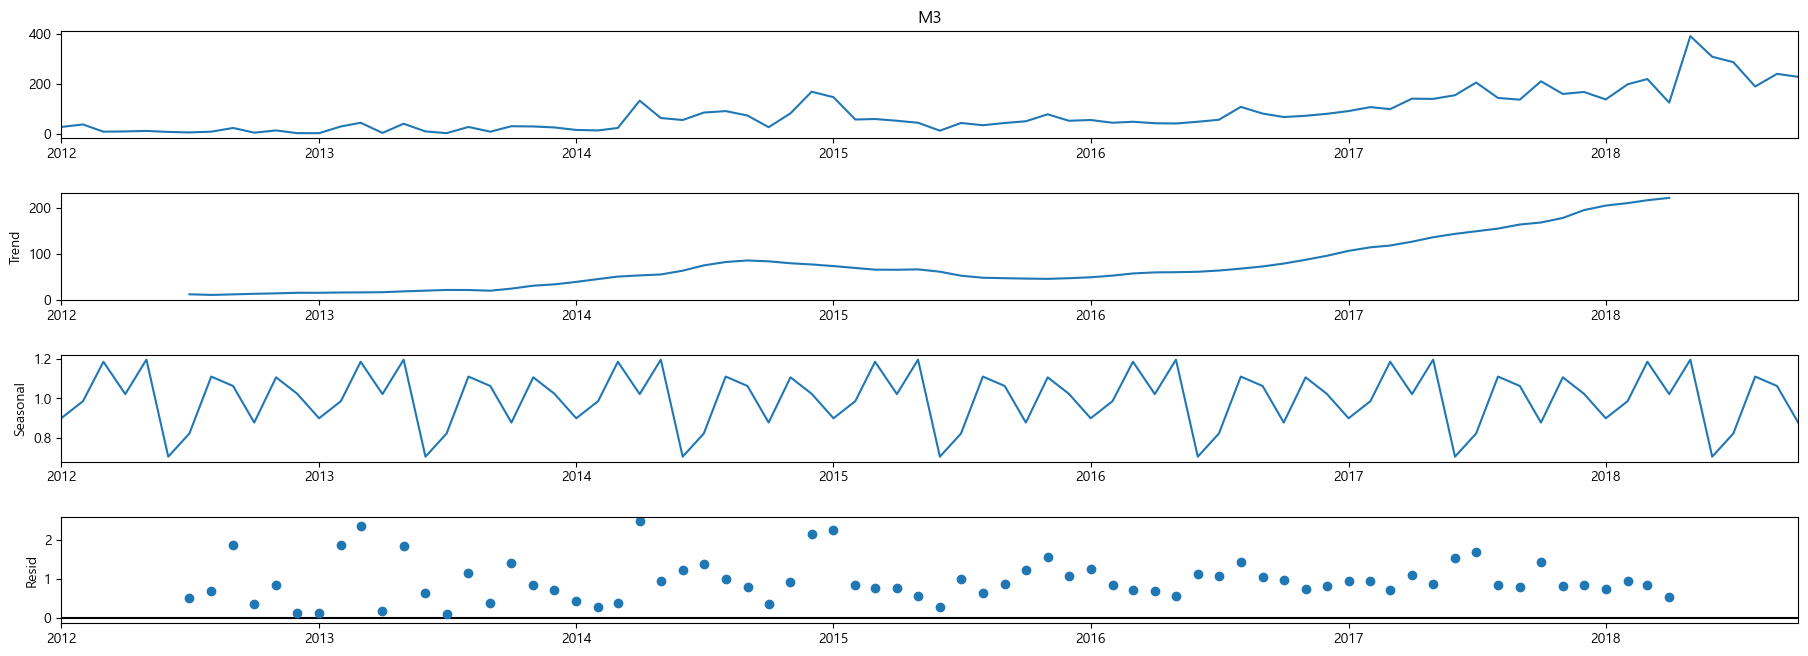

In [20]:
res = seasonal_decompose(df['M3'],model='multiplicative')
res.plot()
plt.gcf().set_size_inches(20, 7)

seasonal_decompose를 통해 곱셈 분해를 실시한다

상위 그래프부터 observed(전체 관측치), Trend(추세), Seasonality(계절성), Residual(잔차)를 나타내준다  

- Trend(추세) = 시간에 따라 우상향
- Seasonality(계절성) = 반복적인 패턴 존재
- Residual(잔차) = 백색잡음(특정 패턴이 없음)

위의 잔차 그래프를 보면 덧셈 분해보다 더욱 민감하게 변화하는 패턴을 확인할 수 있다. 
잔차는 불규칙한 패턴일수록 분석하기 용이하다. 덧셈,곱셈법칙을 적용시켜보고 계절성이 같은 패턴이라면 잔차가 더욱 민감하게 반응하는 법칙으로 활용하는 것이 좋다. 만약, 잔차가 같은 패턴이라면 덧셈 법칙을 활용하는 것이 좋다 

In [21]:
res.observed

Date
2012-01-01     27.0
2012-02-01     37.0
2012-03-01      8.0
2012-04-01      9.0
2012-05-01     11.0
              ...  
2018-06-01    310.0
2018-07-01    288.0
2018-08-01    190.0
2018-09-01    241.0
2018-10-01    229.0
Name: M3, Length: 82, dtype: float64

In [22]:
res.trend

Date
2012-01-01   NaN
2012-02-01   NaN
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   NaN
              ..
2018-06-01   NaN
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
Name: trend, Length: 82, dtype: float64

In [23]:
res.seasonal

Date
2012-01-01    0.900295
2012-02-01    0.986397
2012-03-01    1.184340
2012-04-01    1.021823
2012-05-01    1.195039
                ...   
2018-06-01    0.707353
2018-07-01    0.823849
2018-08-01    1.109924
2018-09-01    1.062558
2018-10-01    0.878859
Name: seasonal, Length: 82, dtype: float64

In [24]:
res.resid

Date
2012-01-01   NaN
2012-02-01   NaN
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   NaN
              ..
2018-06-01   NaN
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
Name: resid, Length: 82, dtype: float64

실제 데이터 값 조회를 통해 observed(전체 관측치), Trend(추세), Seasonality(계절성), Residual(잔차)의 값을 확인할 수 있다. Trend, Residual를 표현하기 위해 앞, 뒤에 일부 데이터가 사라진 것을 알 수 있다

## Arima 활용 시계열 예측

In [27]:
p = d = q = range(0, 2)

import itertools
pdq = list(itertools.product(p, d, q))

seasonal_pdq= [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA')
print("")
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


1. p, d, q

- 0과 2 사이의 값을 취할 p, d, q 매개변수 정의  

2. itertools

- p, d, q 매개변수의 모든 다른 조합 생성

- 모든 경우의 수를 만들어주는 함수  

3. seasonal_pdq

- 계절 p, d, q 매개변수의 모든 다른 조합 생성

- 0, 1, 2번째 순서대로 입력

- 12는 모든 월의 수(1~12월)

In [28]:
df = df.drop(['year', 'month'], axis=1)
df.head(5)

,M3
Date,
2012-01-01,27
2012-02-01,37
2012-03-01,8
2012-04-01,9
2012-05-01,11


예측에 필요 없는 컬럼은 사전에 제거한다

In [30]:
import statsmodels.api as sm
import numpy as np
np.random.seed(1234)
warnings.filterwarnings("ignore")

cols = ['param','param_seasonal','aic']
lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            lst.append([param, param_seasonal, results.aic])
            df1 = pd.DataFrame(lst, columns=cols)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1000.3292122770475
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:831.2496601807413
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:789.7866810047587
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:664.4255818666331
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:792.2054815357808
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:771.4112962840661
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:675.0642816555652
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:666.4239232273679
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:929.4556694697296
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:782.9348700017584
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:760.5470077862781
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:638.0698480454469
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:780.9654398905756
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:752.4203579971718
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:658.8043952235872
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:639.5737300620187
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:845.9343856515544
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:730.531050470379
ARIMA(0, 1

모든 조합의 Parameter 모델을 생성한 후, AIC로 모델 성능을 파악한다. AIC가 작을수록 최적의 모델일 확률이 높다

- try = 오류가 발생하면 넘어가라는 명령어
- 12 = 1년 단위 데이터이기 때문에 주기가 12

In [31]:
df1

,param,param_seasonal,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",1000.329212
1,"(0, 0, 0)","(0, 0, 1, 12)",831.249660
2,"(0, 0, 0)","(0, 1, 0, 12)",789.786681
3,"(0, 0, 0)","(0, 1, 1, 12)",664.425582
4,"(0, 0, 0)","(1, 0, 0, 12)",792.205482
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",600.401288
60,"(1, 1, 1)","(1, 0, 0, 12)",717.133985
61,"(1, 1, 1)","(1, 0, 1, 12)",709.600925
62,"(1, 1, 1)","(1, 1, 0, 12)",614.539441


In [32]:
aic_min=df1['aic'].min()
optimal_para=df1.loc[df1['aic']==aic_min]
optimal_para

,param,param_seasonal,aic
27,"(0, 1, 1)","(0, 1, 1, 12)",599.147141


AIC가 최소가 되는 parameter 조합을 찾는다 

In [33]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6590      0.116     -5.692      0.000      -0.886      -0.432
ma.S.L12      -0.7417      0.367     -2.023      0.043      -1.460      -0.023
sigma2      2630.1017    310.260      8.477      0.000    2022.002    3238.201


AIC가 최소가 되는 parameter 조합을 통해 모델을 학습시킨다

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 M3   No. Observations:                   82
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -296.574
Date:                            Sun, 26 Feb 2023   AIC                            599.147
Time:                                    19:44:43   BIC                            605.169
Sample:                                01-01-2012   HQIC                           601.476
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6590      0.116     -5.692      0.000      -0.886      -0.432
ma.S.L12      -0.7417      0.367     -2.023      0.043      -1.460      -0.023
sigma2      2630.1017    310.260      8.477      0.000    2022.002    3238.201
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                52.36
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             1.28
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

위의 SARIMAX Results는 아래 3가지만 주의해서 살펴보면 된다

1. Ljung-Box : 잔차가 백색잡음을 따르는지(시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기상관을 가지지 않는 백색 잡음)


2. Jarque-Bera : 잔차의 분포가 정규분포를 따르는지


3. Heteroskedasticity : 시간대별 잔차의 분산이 일정한지  

모두 0.05 이상이므로 백색잡음을 따르며, 정규분포이며, 분산이 일정하다

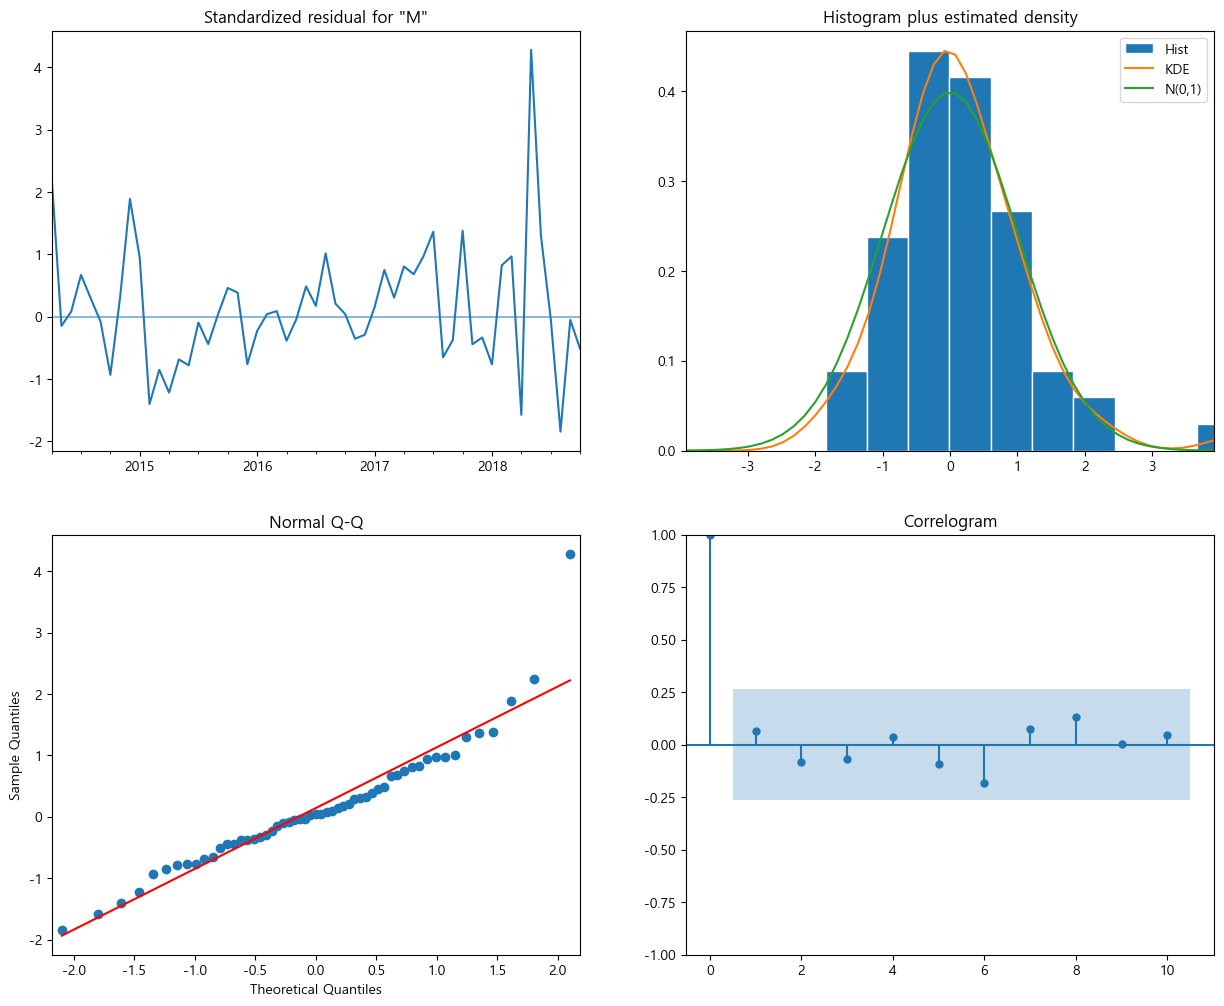

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

위의 생성된 모델 정합성을 확인하는 과정이 필요하다(Arima 모델을 사용할 수 있는지, 잔차가 정상성을 따르는지 판단하는 것)

1. Standardized residual

- 잔차가 백색잡음에 가까울수록 좋다

- 평균 0을 중심으로 백색잡음의 형태가 나타난다  


2. Histogram plus estimated density

- 잔차의 분포가 정규분포를 따르는지 확인(약간 벗어남)

- 잔차의 Hist, KDE, N(0,1)를 정규분포와 비교해본다


3. Normal Q-Q

- 두개의 분포가 같은지 다른지 판단하는 Plot(약간 벗어남)

- x축 : 이론적 샘플분포(정규분포)

- y축 : 자재 발주량


4. Correlogram

- 잔차에 대한 ACF

- 예측된 자기상관성을 나타내기 위한 Plot

- 파란색 박스 안에 들어와 있으면 자기상관성이 없다고 판단할 수 있다

- 자기상관성이 있으면 모델을 사용할 수 없다  


위의 results.plot_diagnostics를 확인한 결과, 약간의 정규성을 벗어나지만 예측에 크게 문제되지 않는다고 판단이 된다. 만약, 예측 후 잘 맞지 않으면 파라미터를 수정 후 재진행을 실시한다

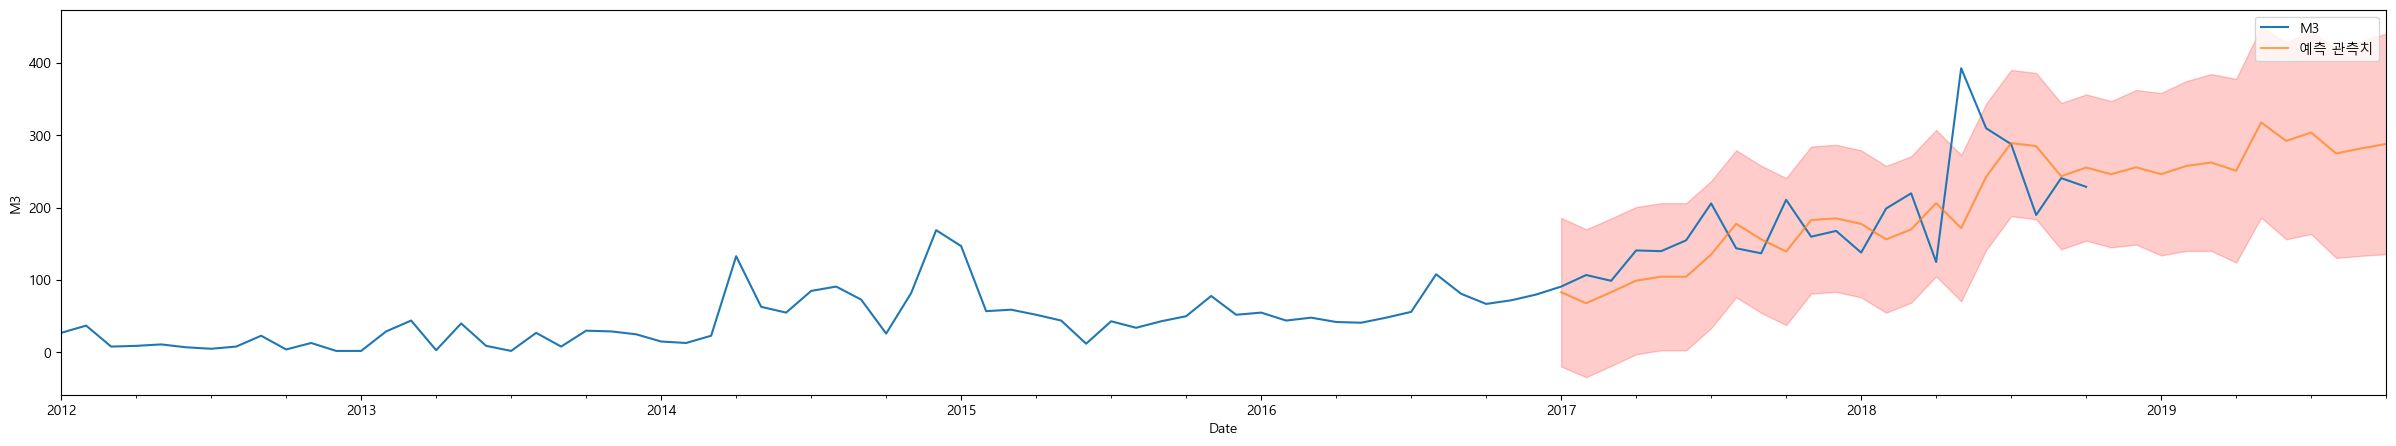

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2019-10-01'), dynamic=False)


pred_ci = pred.conf_int()
ax = df['2012':].plot(label='전체 관측치')
pred.predicted_mean.plot(ax=ax, label='예측 관측치', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('M3')
plt.legend()

plt.rcParams["figure.figsize"] = (60, 5)
plt.show()

results.get_prediction을 통해 2017-01-01부터 2019-10-01까지의 예측을 실시한다

- conf_int : 신뢰구간을 가져오는 함수
- fill_between : 신뢰구간 표시(빨간 부분)  

peak를 예측하는 것이 어려워보인다

In [38]:
y_forecasted = pred.predicted_mean

y_truth = df['2017-01-01':]

mse = ((y_forecasted - y_truth['M3']) ** 2).mean()
print('MSE : ', round(mse, 2))

mae = (abs(y_forecasted - y_truth['M3'])).mean()
print('MAE : ', round(mae, 2))

MSE :  4345.03
MAE :  47.93


- mse : 이상치에 적합함


- rmse : mse 단위를 보기 쉽게 하기 위함


- mae : 실제값과 예측값의 차이

In [39]:
cols = ['y_truth','y_forecasted']
dat = []
result=pd.DataFrame(dat,columns=cols)
y_real=df['2017-01-01':]

result['y_forecasted']=y_forecasted
result['y_truth']=y_real['M3']
result['diff'] = result['y_truth'] - result['y_forecasted']
result

,y_truth,y_forecasted,diff
2017-01-01,91.0,83.175757,7.824243
2017-02-01,107.0,67.938830,39.061170
2017-03-01,99.0,83.200814,15.799186
2017-04-01,141.0,99.200742,41.799258
2017-05-01,140.0,104.656336,35.343664
2017-06-01,155.0,104.631222,50.368778
2017-07-01,206.0,135.285839,70.714161
2017-08-01,144.0,177.907443,-33.907443
2017-09-01,137.0,156.424170,-19.424170
2017-10-01,211.0,139.425423,71.574577


diff 변수에 실제값과 예측값의 차이를 한눈에 파악할 수 있게 새로 생성한다

위의 데이터는 2018-10-01까지만 존재하기에 2018-11-01부터 결측치가 존재하는 것이다. 따라서, 2018-11부터의 예측 발주량을 가지고 재고계획수립을 진행하면 된다. 현업의 판단하에 수요 예측기간을 설정하고 조정하면 된다

성과측정은 기본 베이스 코드(위의 전체 코드)를 가지고 익월 데이터를 추가 업로드해서 성과비교가 필요하다. 예를 들어, 위의 데이터로 예측한 발주량를 기반으로 재고관리를 통한 감소 비용 측정을 통해 비교하는것이다